In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
data=pd.read_csv('/content/cleaned_data_telecomchurn.csv')

In [2]:
data[['registration_year', 'registration_month', 'registration_day','num_dependents','single or not']].head()

,registration_year,registration_month,registration_day,num_dependents,single or not
0,2020.0,1.0,1.0,4.0,Not single
1,2020.0,1.0,1.0,2.0,Not single
2,2020.0,1.0,1.0,0.0,Single
3,2020.0,1.0,1.0,1.0,Not single
4,2020.0,1.0,1.0,2.0,Not single


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18806 entries, 0 to 18805
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           18806 non-null  int64  
 1   telecom_partner      18806 non-null  object 
 2   gender               18806 non-null  object 
 3   age                  18806 non-null  int64  
 4   age_decay_range      18806 non-null  int64  
 5   age_interval         18806 non-null  object 
 6   state                18806 non-null  object 
 7   city                 18806 non-null  object 
 8   region               18806 non-null  object 
 9   registration_year    18805 non-null  float64
 10  registration_month   18805 non-null  float64
 11  registration_day     18805 non-null  float64
 12  num_dependents       18805 non-null  float64
 13  single or not        18805 non-null  object 
 14  estimated_salary     18805 non-null  float64
 15  calls_made           18805 non-null 

In [4]:
data_scaled = data.copy()

In [5]:
#Encode 'single or not': Single = 1, Not single = 0
data_scaled['single_or_not_encoded'] = data_scaled['single or not'].map({'Single': 1, 'Not single': 0})

In [6]:
data_scaled[['single or not']].value_counts()

,count
single or not,
Not single,14997
Single,3808


In [7]:
data_scaled[['single or not', 'single_or_not_encoded']].head()

,single or not,single_or_not_encoded
0,Not single,0.0
1,Not single,0.0
2,Single,1.0
3,Not single,0.0
4,Not single,0.0


In [8]:
registration_data = data[['registration_year', 'registration_month', 'registration_day']].rename(
    columns={
        'registration_year': 'year',
        'registration_month': 'month',
        'registration_day': 'day'
    }
)
data['registration_date'] = pd.to_datetime(registration_data[['year', 'month', 'day']])

In [9]:
# 2. Extract useful features from registration_date
data['registration_dayofweek'] = data['registration_date'].dt.dayofweek  # Monday=0, Sunday=6
data['registration_dayofyear'] = data['registration_date'].dt.dayofyear
data['days_since_registration'] = (pd.to_datetime("today") - data['registration_date']).dt.days

In [10]:
# 3. Choose numeric columns for standardization (excluding ID columns and target)
numeric_cols = ['registration_dayofweek', 'registration_dayofyear', 'days_since_registration']

In [11]:
# Apply Standardization
scaler = StandardScaler()
data_scaled = data.copy()
data_scaled[numeric_cols] = scaler.fit_transform(data[numeric_cols])

In [12]:
# Show the transformed features
data_scaled[numeric_cols + ['churn']].head()

,registration_dayofweek,registration_dayofyear,days_since_registration,churn
0,-0.508053,-1.713621,1.713621,0.0
1,-0.508053,-1.713621,1.713621,0.0
2,-0.508053,-1.713621,1.713621,1.0
3,-0.508053,-1.713621,1.713621,1.0
4,-0.508053,-1.713621,1.713621,0.0


In [20]:
# Import required libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns


In [21]:

# 3. Select features and target
X = data_scaled[['age', 'num_dependents', 'single_or_not_encoded',
                'estimated_salary', 'calls_made', 'sms_sent', 'data_used',
                'registration_dayofweek', 'registration_dayofyear',
                'days_since_registration']]
y = data_scaled['churn']



In [22]:
# 4. Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
# 5. Initialize and train the logistic regression model
logreg = LogisticRegression(max_iter=100, random_state=42)
logreg.fit(X_train, y_train)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [26]:
# 6. Make predictions
y_pred = logreg.predict(X_test)
y_pred_proba = logreg.predict_proba(X_test)[:, 1]  # Probabilities for ROC curve

In [32]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)


Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89      3016
         1.0       0.00      0.00      0.00       745

    accuracy                           0.80      3761
   macro avg       0.40      0.50      0.45      3761
weighted avg       0.64      0.80      0.71      3761


Confusion Matrix:


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


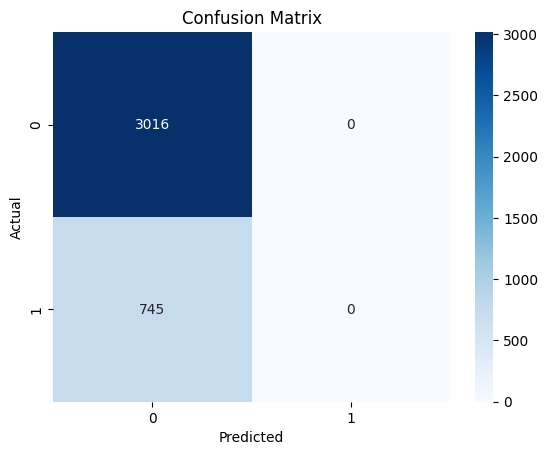

In [33]:
# 7. Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [34]:
# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")



Accuracy: 0.8019


In [37]:
# Calculate and print ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

ROC AUC Score: 0.4968


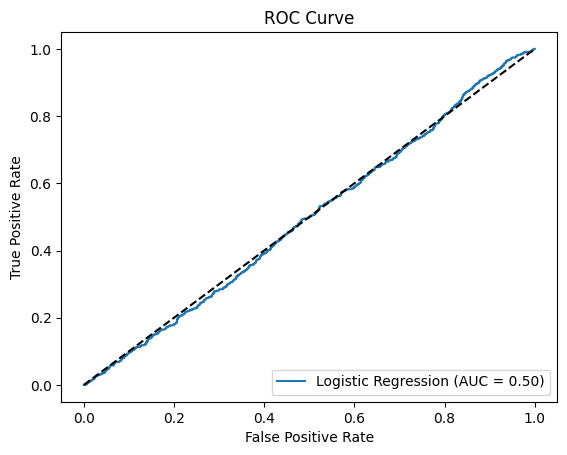

In [36]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


In [38]:
# Feature importance
importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': logreg.coef_[0]
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(importance)


Feature Importance:
                   Feature  Importance
9  days_since_registration    0.009824
3         estimated_salary   -0.000003
6                data_used   -0.000026
4               calls_made   -0.002748
2    single_or_not_encoded   -0.003090
7   registration_dayofweek   -0.003452
5                 sms_sent   -0.006218
8   registration_dayofyear   -0.009824
0                      age   -0.010163
1           num_dependents   -0.087457
